## The Beginning of a Deep Learning Journey
This notebook is based on what I learned in chapter 1 and 2 of the book "Practical Deep Learning for Coders". The model built here will successfully categorize the logo for any team that played in the English Premier League in the 2021/22 season. While everyone else is waiting for scalable quantum chips, I'm doing the important work of ensuring you can successfully tell which team crest is which in the event you temporarily lose the ability to read English. 

All joking aside, the fact that the team name is printed on most crests AND the model is capable of getting the categorization wrong reveals quite a lot about how these computer vision models work and some of the potential pitfalls of deep learning in general. I will demonstrate an example of this below.

*Note: It's quite possible that the "issue" I demonstrate with an overtrained model below is easily fixed by someone with a better or more advanced understanding of deep learning. It is also possible that resnet18 was not the best pre-trained model to pick for this task. Please keep in mind this is my personal learning journey and so don't judge too harshly :)*

In [2]:
from fastai.vision.all import *

### The initial plan... and why it failed
I originally wanted to train a model to categorize players with their team based on a photo. So, if I uploaded a photo of a soccer player the model would be able to tell me what team they played for. This turned out to be incredibly challenging for two main reasons. 
1. The image search API lauded in the FastAI book is no longer available. I was unable to quickly find a free alternative and chose to focus on this project instead of falling into a github rabbit hole and getting my identity stolen.
2. The amount of images I *think* I would need to accomplish this task is massive given my current understanding of how these vision models work. For example, how am I going to train a vision model to differentiate between two players with similar color skin, hair, and the same color uniform? Think Bukayo Saka from Arsenal and Ibrahima Konate from Liverpool. I don't think they look anything alike, but how many pictures will it take to teach a model to differentiate between them?

Luckily, I was able to find a delightful data set from Alex Teboul that had 20,000 images of team logos from the 2021/22 Premier League season. This man is a hero. Here is a link to his dataset.
https://www.kaggle.com/datasets/alexteboul/english-premier-league-logo-detection-20k-images

In [3]:
path = "/kaggle/input/english-premier-league-logo-detection-20k-images"
fns = get_image_files(path)
len(fns)

20000

### Preparing the data
The code below is an example of FASTAI's datablock API. It allows you to customize your "dataloader" which is a fancy word for the python class that will input data into your model for training and validation. In broad strokes we have a bunch of images (the team logos) and a bunch of categories (the team name associated with the logo image). We create a training set where we tell the computer which image belongs to which category and the model figures out how to match the two based on thousands of examples. Then we validate the model with the validation set and repeat the process as many times as desired for a given level of accuracy.

In [4]:
teams = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = teams.dataloaders(path)

### Example training data
The images below are examples of training data. According to the FastAI book, it is best practice when training these vision models to randomly transform the images. This attempts to normalize the images that may all be different sizes and resolutions etc. 

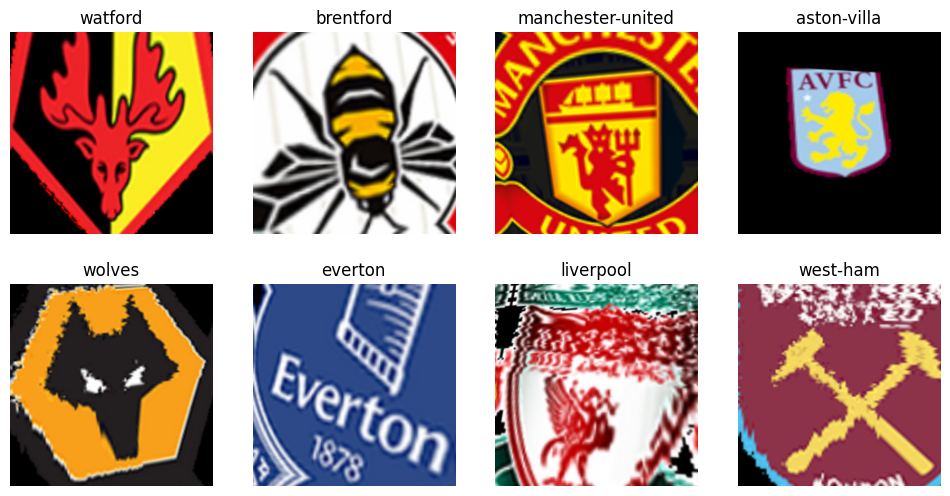

In [9]:
dls.train.show_batch(max_n=8)

### Example validation data
Here is an example of the validation data. You will notice it looks a lot like the training data. Keep in mind that, in both cases (training and validation), there are thousands of images being used to train the model and not just 8.

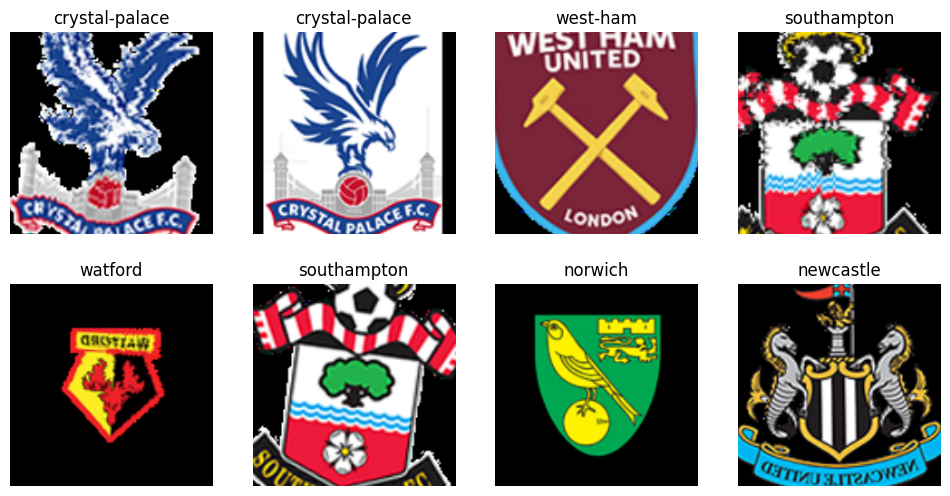

In [10]:
dls.valid.show_batch(max_n=8)

### The model
This is where the "magic" happens. I use the dataloader and a pre-trained model called resnet18 to accomplish my goal. According to the FastAI book, resnet18 is a very widely used computer vision model. Using this pre-trained model and the GPUs provided by Kaggle (thanks Kaggle!) I was able to train a model to a 0% error rate in less than 2 minutes.

I know enough about machine learning to be suspicious of this error rate. It immediately screams "over-training" and more experienced practitioners are probably shaking their head (if they've even read this far). As we will see below, my concerns were well placed.

In [5]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,0.070656,0.001745,0.000500,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.003965,0.000036,0.000000,01:00


## The test
I love Arsenal FC, and so I chose to test my model with an Arsenal logo. The Arsenal logo clearly states what team it represents so I chose an image with some non-standard features (the wreaths around the logo). I still considered this to be an "easy" test as this logo had most (maybe all) of the features that would have been identified in the training set.

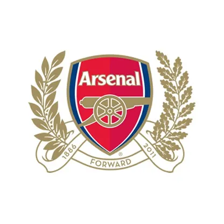

In [11]:
easy_arsenal = Image.open("/kaggle/input/prediction-data/arsenal_416x416.webp").to_thumb(224,224)
easy_arsenal

The model was able to successfully identify the logo as belonging to Arsenal with a confidence of 99% (the first entry in the "tensor" list provides this percentage). 

In [12]:
learn.predict(easy_arsenal)

('arsenal',
 tensor(0),
 tensor([9.9687e-01, 2.5484e-05, 9.6396e-05, 5.0693e-05, 1.2382e-04, 8.7785e-07,
         2.3679e-06, 2.4488e-05, 3.7749e-05, 2.2858e-04, 2.4329e-04, 2.2373e-03,
         8.5827e-07, 2.9412e-07, 2.0097e-05, 5.9347e-06, 8.2644e-06, 9.5571e-06,
         1.6583e-05, 1.3678e-06]))

### The test... goes on
This is all well and good, but what about logos that are non-standard. I found a logo that does not match the traditional color scheme, is tilted, and has a shadow effect. I was really curious how the model would perform with this image.

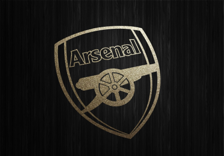

In [13]:
hard_arsenal = Image.open("/kaggle/input/prediction-data/Arsenal-Logo-Wallpaper-2016.jpg").to_thumb(224,224)
hard_arsenal

Disaster! The model identified the logo as an "Everton" logo with 86% confidence!!! I have nothing against Everton, but this is very wrong. Maybe the model got confused because Arsenal's current manager used to play for Everton?

In [14]:
learn.predict(hard_arsenal)

('everton',
 tensor(7),
 tensor([7.3380e-02, 2.3764e-03, 7.3727e-04, 2.8321e-03, 1.8524e-04, 2.9896e-04,
         9.1982e-05, 8.6333e-01, 7.4399e-04, 1.4338e-02, 9.0090e-03, 1.4515e-03,
         1.9741e-04, 8.4280e-05, 1.6883e-02, 1.2712e-04, 4.4225e-03, 6.0973e-04,
         6.5824e-03, 2.3226e-03]))

What's more likely is that this model is over-trained. It performs *extremely* well with the training and validation set, but not so well with "real" data. I suspected this was the case when I saw such low error rates in the original training report. I suspect this is a testament to how good resnet18 is out of the box combined with the extremely robust data set I used for training. I was a little nervous that it had over-trained so quickly, but I decided to re-train the model by training it as little as possible. 53 seconds later. I was ready to test again.

### Re-train

In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(0)

epoch,train_loss,valid_loss,error_rate,time
0,0.068663,0.001542,0.000250,00:53


### The final countdown... sorry, test
You can see the results of my test on the new model below. The new model was successfully able to identify both logos as Arsenal logos. It was "only" 77% confident of the hard_arsenal logo, but at least it got it right. 

In [17]:
learn.predict(easy_arsenal)

('arsenal',
 tensor(0),
 tensor([9.8703e-01, 2.1202e-04, 1.5228e-03, 9.7909e-06, 6.4679e-05, 3.1292e-06,
         1.7925e-05, 2.2871e-03, 8.7827e-04, 7.9331e-04, 8.4432e-05, 5.6646e-03,
         1.1422e-05, 7.5445e-05, 1.3595e-05, 2.3669e-05, 2.6434e-05, 6.5499e-06,
         1.1947e-03, 7.8829e-05]))

In [18]:
learn.predict(hard_arsenal)

('arsenal',
 tensor(0),
 tensor([7.6938e-01, 8.5905e-03, 1.4218e-03, 1.8990e-03, 2.3385e-03, 4.9859e-03,
         8.6695e-05, 2.9561e-02, 8.4762e-04, 1.0896e-02, 2.1039e-03, 1.1848e-03,
         1.1517e-03, 1.3436e-03, 8.1493e-04, 4.0727e-04, 2.8477e-03, 9.4818e-04,
         1.3904e-01, 2.0150e-02]))

### Conclusions
I'm not 100% sure that this is a "classic" overtraining situation. I don't know enough (or anything) about resnet18 to say much more about this. I thought it was an interesting example of how easy it is to develop deep learning (AI?) models, but I probably did many things inefficiently or outright wrong. Perhaps I will return to this "problem" later after I've gone through more of the book.